In [2]:
cd /home/tkim/Academics/DistMEC/

/home/tkim/Academics/DistMEC


In [3]:
import numpy as np
import matplotlib.pyplot as plt

from classes.User import *
from classes.solver import *
from classes.Server import *
from classes.distributed_utils import *

from tqdm import tqdm, tqdm_notebook
from time import sleep
import pickle
import os
import numpy as np

In [4]:
# System Parameters
T = 20000
num_users = 6
num_svrs = 9
num_locs = 9
mu = np.random.uniform(low=0, high = 1, size = [num_users, num_svrs])
ceiling = 30
# w = np.random.uniform(low=0, high=1, size= [num_users, num_svrs])
space_1d_dim = 10 #4 for small, 10 for big

num_explore = 1
trials = 3

# result dictionaries
result_dicts = []
performance_list = []
user_dicts = []

save_name = 'results/22_06_16_ceiling_20/'
isExist = os.path.exists(save_name)
if not isExist:
  # Create a new directory because it does not exist 
    os.makedirs(save_name)


# Generate visitng locations and server locations
usr_locs = gen_eq_locs(space_1d=space_1d_dim, nums=num_locs,offset = 1.7)
svr_locs = gen_eq_locs(space_1d=space_1d_dim, nums=num_svrs,offset = 1.7)

with open('traces_P_40k.pkl', 'rb') as handle:
    P_collection = pickle.load(handle)
    
with open('traces_P_40k_dict.pkl', 'rb') as handle:
    P_dict = pickle.load(handle)

# Create Users
Users = []
for i in range(num_users):
    P_chosen = P_collection
#     P_chosen = P_dict[list(P_dict)[i]]
    Users += [User(usr_locs,svr_locs,mu[i],i,
                  max_dist = 5, threshold_dist = 6, self_weight = 1 - 0.95, P = P_chosen, ceiling = ceiling,
                  sticky_mode = True, kick_mode=True)]

GoT_Users = []
for i in range(num_users):
    GoT_Users += [GoT_User(usr_locs, svr_locs, mu[i], i, 
                 max_dist = 5, threshold_dist = 6, self_weight = 1 - 0.95, P = Users[i].P,
                 c1 = 5000, c2 = 6000, c3 = 6000, delta = 0, rho = 0.5, epsilon = 0.01,
                 c = num_users, horizon = T)]
    
# Create Servers
Servers = []
for i in range(num_svrs):
    Servers += [Server(svr_locs[i],mu,i)]

# Recorded Values - reservation
regret_g = np.zeros(T)
collision_count_g = np.zeros(T)
optimal_reward_g = np.zeros(T)
regret_g_compstat = np.zeros(T)

regret = np.zeros(T)
collision_count = np.zeros(T)
optimal_reward = np.zeros(T)


explore_rounds(Users, num_users, Servers, mu, regret, collision_count, optimal_reward,
                   usr_move_flag = True, rounds=num_explore)

round_start = ((num_svrs)*num_explore)+1

for t in range(round_start):
    w = obtain_w(GoT_Users, len(Users), len(Servers))
    optimal = offline_optimal_action(w, mu)
    play_round(GoT_Users, Servers, mu, regret_g, collision_count_g, 
               usr_move_flag = True, debugger=False, reservation_mode = False, optimal=optimal, t = t)
    
copy_usr_loc(Users, GoT_Users)

# Centralized - stationary w, known mu
w_stat = obtain_w_stationary(Users, num_users, num_svrs)
optimal_stat_arms = offline_optimal_action(w_stat,mu)[0]
regret_cst = copy.deepcopy(regret)

for (zzz,t) in zip(tqdm_notebook(range(T-round_start)),range(round_start, T)):
    w = obtain_w(Users, len(Users), len(Servers))
    optimal = offline_optimal_action(w, mu)
    optimal_reward[t] = optimal[1]
    play_round(Users, Servers, mu, regret, collision_count, 
               usr_move_flag = True, debugger = False, reservation_mode = True, optimal =optimal, t = t)
    play_round(GoT_Users, Servers, mu, regret_g, collision_count_g, 
               usr_move_flag = False, debugger=False, reservation_mode = False, optimal=optimal, t = t)
    copy_usr_loc(Users, GoT_Users)
    
    # centralized solution - stationary w, known mu
    regret_cst[t] = optimal[1] - expected_reward(optimal_stat_arms, mu, w) 
    regret_g_compstat[t] = regret_g[t] - regret_cst[t]

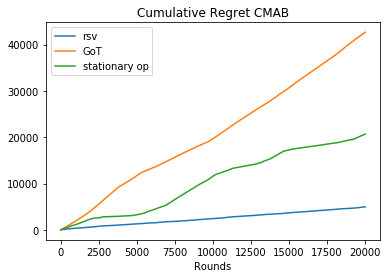

In [5]:
plot_idx = 1

plt.plot(np.cumsum(regret), label = 'rsv')
plt.plot(np.cumsum(regret_g), label = 'GoT')
plt.plot(np.cumsum(regret_cst), label = 'stationary op')
plt.title('Cumulative Regret CMAB')
plt.xlabel('Rounds')
plt.legend()

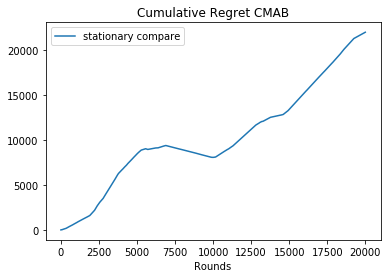

In [6]:
plot_idx = 1

plt.plot(np.cumsum(regret_g_compstat), label = 'stationary compare')
plt.title('Cumulative Regret CMAB')
plt.xlabel('Rounds')
plt.legend()

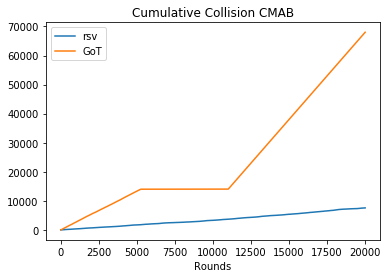

In [7]:
plot_idx = 1

plt.plot(np.cumsum(collision_count), label = 'rsv')
plt.plot(np.cumsum(collision_count_g), label = 'GoT')
plt.title('Cumulative Collision CMAB')
plt.xlabel('Rounds')
plt.legend()

In [7]:
got_arms = []
for i in range(len(GoT_Users)):
    got_arms += [GoT_Users[i].Fmax_idx]

In [8]:
optimal[0]

[1, 3, 7, 4, 6, 0]

In [9]:
optimal_stat_arms

[1, 6, 2, 5, 3, 0]

In [10]:
got_arms

[0, 0, 0, 0, 0, 0]

In [11]:
for i in range(len(GoT_Users)):
    print(GoT_Users[i].Ftni)

[0.000e+00 2.000e+01 0.000e+00 5.776e+03 2.000e+00 0.000e+00 2.000e+00
 0.000e+00 0.000e+00]
[0.000e+00 1.000e+00 2.000e+00 9.000e+00 1.400e+01 5.200e+01 3.000e+01
 5.758e+03 2.000e+00]
[0.000e+00 0.000e+00 0.000e+00 2.000e+00 0.000e+00 0.000e+00 5.786e+03
 1.300e+01 0.000e+00]
[0.000e+00 0.000e+00 5.787e+03 1.900e+01 4.100e+01 7.000e+00 4.000e+00
 0.000e+00 0.000e+00]
[2.000e+00 5.758e+03 0.000e+00 6.200e+01 7.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00]
[5822.    0.    0.    0.    0.    0.    0.    0.    0.]


In [12]:
GoT_Users[i].Fmax_idx

0